# Dynamic Allocation Logs Visualization

This notebook can be used to visualize the requests, registrations, and terminations of Spark Executors logged during a workload execution. 

> Note: Due to some issues with the Event Log, the current method parses a log file using regular expressions to extract the required information. 
> A future version could replace the current method by parsing the event log instead.

## Imports and Defintions

In [7]:
DIR_LOGS = '../data/dynalloc-logs'

PATTERNS = {
    'requested': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.ExecutorPodsAllocator\s-\sGoing\sto\srequest\s(\d+)\sexecutors',
    'request_deleted': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.ExecutorPodsAllocator\s-\sDeleting\s(\d+)\sexcess\spod\srequests',
    'registered': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.dynalloc.ExecutorMonitor\s-\sNew executor \d+ has registered \(new total is (\d+)\)',
    'removed': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.dynalloc.ExecutorMonitor\s-\sExecutor \d+ is removed',
    'kill_request': r'^(\d+)\s\[.*?\]\sINFO\sorg.apache.spark.scheduler.cluster.k8s.KubernetesClusterSchedulerBackend\s-\sRequesting to kill executor\(s\) (.+)$',
    'end': r'^(\d+)\sWORKLOAD_END$'
}

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
from helpers.timeline import get_timeline

In [9]:
def get_converted_time(timestamp, start_time):
    return int(timestamp) / 1000 - start_time 

def get_requests(log, start_time):

    def get_time(timestamp):
        return get_converted_time(timestamp, start_time)

    matches = re.finditer(PATTERNS['requested'], log, re.MULTILINE)
    requests = []
    for match in matches:
        time, count = match.groups()
        requests.append((get_time(time), int(count)))
    
    matches = re.finditer(PATTERNS['request_deleted'], log, re.MULTILINE)
    for match in matches:
        time, count = match.groups()
        requests.append((get_time(time), -int(count)))

    matches = re.finditer(PATTERNS['kill_request'], log, re.MULTILINE)
    for match in matches:
        time, list = match.groups()
        count = len(list.split(','))
        requests.append((get_time(time), -count))
    
    return(sorted(requests))

def get_registrations(log, start_time):

    def get_time(timestamp):
        return get_converted_time(timestamp, start_time)
    
    matches = re.finditer(PATTERNS['registered'], log, re.MULTILINE)
    registrations = []

    for match in matches:
        time, total = match.groups()
        registrations.append((get_time(time), +1))
    
    matches = re.finditer(PATTERNS['removed'], log, re.MULTILINE)
    for match in matches:
        time, = match.groups()
        registrations.append((get_time(time), -1))

    return(sorted(registrations))

def get_end(log, start_time):

    matches = re.finditer(PATTERNS['end'], log, re.MULTILINE)
    matches = list(matches)

    time = None

    # should never be more than one, but if so, take the last one.
    # alternative: raise exception?
    for match in matches:
        time, = match.groups()
        time = get_converted_time(time, start_time)
    
    return time

In [10]:
def plot_executors(session_id, start_offset=0, xmin=None, xmax=None, xticks=None, xshift=0, xlabel="Time [s]", 
                   xjitter=0, yjitter=0, width=None, height=None, debug=False):

    workload, time = session_id.split('/')
    time = int(time)

    dir = f"{DIR_LOGS}/{workload}/{time}"
    file_list = os.listdir(dir)

    logs = {}

    for filename in file_list:
        if filename.endswith('.log'):
            with open(f'{dir}/{filename}', 'r') as file:
                content = file.read()
                logs[filename.strip('.log')] = content

    fig, ax = plt.subplots(1, 1)

    fig.set_figwidth(20)

    if width is not None:
        fig.set_figwidth(width)
    if height is not None:
        fig.set_figheight(height)

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Executors')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = iter(prop_cycle.by_key()['color'])

    for i, app in enumerate(sorted(logs.keys())):
        end_time = get_end(logs[app], time)

        requests = get_requests(logs[app], time)
        registrations = get_registrations(logs[app], time)
        requests_timeline = get_timeline(requests, end_time)
        registrations_timeline = get_timeline(registrations, end_time)
        if debug:
            print(requests)
            print(requests_timeline)

        requests_x, requests_y = zip(*requests_timeline)
        registered_x, registered_y = zip(*registrations_timeline)

        if xshift != 0:
            requests_x = list(map(lambda x: x + xshift, requests_x))
            registered_x = list(map(lambda x: x + xshift, registered_x))

        if xjitter != 0:
            requests_x = list(map(lambda x: x + xjitter * i, requests_y))
            registered_x = list(map(lambda x: x + xjitter * i, registered_y))

        if yjitter != 0:
            requests_y = list(map(lambda y: y + yjitter * i, requests_y))
            registered_y = list(map(lambda y: y + yjitter * i, registered_y))

        color = next(colors)
        ax.plot(requests_x, requests_y, color=color, linestyle='dashed', label=f'App {app} (Req.)')
        ax.plot(registered_x, registered_y, color=color, label=f'App {app} (Reg.)')
        
    ax.set_xlim(left=xmin, right=xmax)

    if xticks is not None:
        ax.set_xticks(xticks)

    ax.legend()

## Usage

This section demonstrates how the visualization function can be used. Note that the data of workload runs is not part of this repository, and thus this code will fail unless the data is added is first.

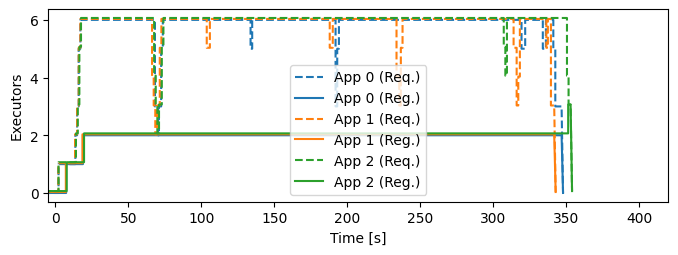

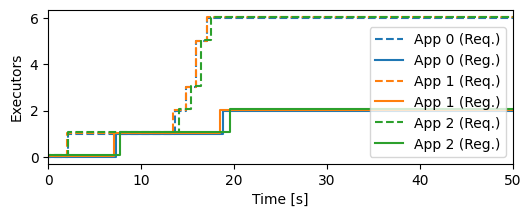

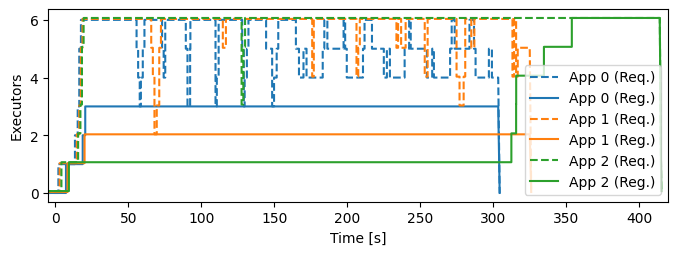

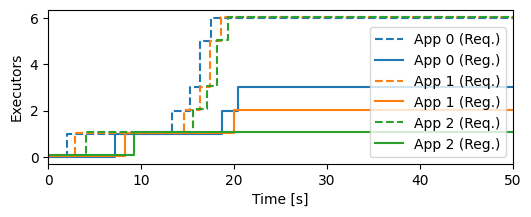

In [11]:
session_id = 'constant-equal-i4l60sf375d300id240_3/1719081235'
plot_executors(session_id, xshift=-240, xmin=-5, xmax=420, yjitter=.033, height=2.5, width=8)
plot_executors(session_id, xshift=-240, xmin=0, xmax=50, yjitter=.033, height=2, width=6)
session_id = 'constant-equal-i4l60sf375d300id240os1_3/1719082845'
plot_executors(session_id, xshift=-240, xmin=-5, xmax=420, yjitter=.033, height=2.5, width=8)
plot_executors(session_id, xshift=-240, xmin=0, xmax=50, yjitter=.033, height=2, width=6)